# [모의 경진대회] 토지피복지도 객체 분할

- 이미지 세그멘테이션

In [1]:
!nvidia-smi

Wed Nov 30 18:15:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !unzip /content/drive/MyDrive/Project/kaggle-2nd-mock-competition/landmap/DATA/train.zip -d /content/drive/MyDrive/Project/kaggle-2nd-mock-competition/landmap/DATA

In [4]:
# !unzip /content/drive/MyDrive/Project/kaggle-2nd-mock-competition/landmap/DATA/test.zip -d /content/drive/MyDrive/Project/kaggle-2nd-mock-competition/landmap/DATA

## 필수 라이브러리 불러오기

In [5]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

import albumentations as A
import cv2
from datetime import datetime, timezone, timedelta

## 경로 & 인자 설정

#### 데이터 경로

In [7]:
# 프로젝트 경로
PROJECT_DIR = '/content/drive/MyDrive/Project/kaggle-2nd-mock-competition/landmap'
os.chdir(PROJECT_DIR)

#데이터 경로
DATA_DIR = os.path.join(PROJECT_DIR, 'DATA') # 모든 데이터가 들어있는 폴더 경로
TRAIN_DIR = os.path.join(DATA_DIR, 'train') # 학습 데이터가 들어있는 폴더 경로
TRAIN_IMG_DIR = os.path.join(TRAIN_DIR, 'images') # 학습 이미지가 들어있는 폴더 경로
TRAIN_MASK_DIR = os.path.join(TRAIN_DIR, 'masks') # 학습 마스크가 들어있는 폴더 경로
TRAIN_CSV_FILE = os.path.join(TRAIN_DIR, 'traindf.csv') # 학습 이미지와 마스크 이름이 들어있는 CSV 경로

### 데이터 수량 확인:
- n_train = 3930
- n_test = 3930

In [8]:
# len(os.listdir(TRAIN_IMG_DIR)) #3930

In [9]:
# len(os.listdir(TRAIN_MASK_DIR)) #3930

#### 시드 설정

In [10]:
RANDOM_SEED = 42 #랜덤 시드

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

#### 디바이스 설정

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 데이터 불러오기 및 분할

In [12]:
# 학습 이미지, 마스크 이름 들어있는 CSV 불러와 데이터 프레임으로 저장
entiredf = pd.read_csv(TRAIN_CSV_FILE)

# Train과 Validation 데이터셋으로 나누기
traindf, validdf = train_test_split(entiredf, test_size=0.2, random_state= random.seed(RANDOM_SEED))
traindf = traindf.reset_index(drop=True)
validdf = validdf.reset_index(drop=True)

## Dataset 정의

### Dataset 클래스 정의

In [13]:
class SegDataset(Dataset):
    def __init__(self, df, augmentations, img_dir, mask_dir):
        self.df = df # 이미지와 마스크 이름이 저장된 데이터프레임 
        self.augmentations = augmentations # 학습 전 적용할 augmentation
        self.img_dir = img_dir # 이미지 폴더 경로
        self.mask_dir = mask_dir # 마스크 폴더 경로
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 데이터 프레임 불러와서 이미지와 마스크 경로 설정
        row = self.df.iloc[idx] # 데이터프레임 행 불러오기
        image_path = os.path.join(self.img_dir,row['img'])
        mask_path = os.path.join(self.mask_dir, row['mask'])
        
        # 이미지와 마스크 불러오기
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        
        # Augmentation 적용하기
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        # PyTorch 인풋 모양에 맞게 이미지와 마스크 모양 변경
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)
        
        # 이미지 Normalization 0~255 픽셀값 --> 0~1 픽셀값
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask)/255.0)
        
        return image, mask

## 모델 정의

### 모델 Class 생성

In [14]:
ENCODER = 'timm-efficientnet-b4' # 활용할 인코더 모델
WEIGHTS = 'imagenet' # Pre-train에 활용된 데이터셋

In [15]:
F = nn.functional

class SegModel(nn.Module):
    def __init__(self):
        super(SegModel, self).__init__()
        
        # Pre-train된 UNET 불러오기
        self.backbone = smp.Unet(
            encoder_name = ENCODER, # 인코더 모델 설정
            encoder_weights = WEIGHTS, # 사전학습 데이터셋 설정
            in_channels = 3, # 이미지 디멘션 (3 * 512 * 512)
            classes = 1, # 세그멘테이션 클래스 개수 
            activation = None # logit 값 불러오기
        )
        
    def forward(self, images):
        output = self.backbone(images)
        
        return output

## Utils 정의
#### Augmentation 함수

In [16]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE), # 이미지 크기 변환
        A.HorizontalFlip(p=0.5), # 이미지 좌우반전
        A.VerticalFlip(p=0.5) # 이미지 상하반전
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

## Dataset & Dataloader 생성

In [17]:
# timm-efficientnet-b4
BATCH_SIZE = 16
IMG_SIZE = 512

In [18]:
# Dataset 및 Dataloader 설정

train_dataset = SegDataset(traindf, get_train_augs(), TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_dataset = SegDataset(validdf, get_valid_augs(), TRAIN_IMG_DIR, TRAIN_MASK_DIR)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

## 학습

### Custom Loss Function 설정

In [19]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [20]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

#### 하이퍼파라미터 설정

In [21]:
# Efficientnet
epoch = 80
max_lr = 1e-3 # 러닝레이트
weight_decay = 1e-4 # orverfitting 방지

#### Train 함수

In [22]:
# def train_fn(dataloader, model, optimizer, loss_fn):
#     print('--- Training ---')

#     model.train()
    
#     total_loss = 0.0
    
#     for images,masks in tqdm(dataloader):
#         images = images.to(DEVICE)
#         masks = masks.to(DEVICE)
#         optimizer.zero_grad()
#         logits = model(images)

#         if LOSS_FUNCTION == 'dice':
#             loss = loss_fn(logits, masks) # Dice LossFunction
#         elif LOSS_FUNCTION == 'miou':
#             loss = mIoU(logits, masks) # mIoU LossFunction
        
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
        
#     return total_loss/len(dataloader)

#### Validation 함수

In [23]:
# def valid_fn(dataloader, model, loss_fn):
#     print('--- Validation ---')

#     model.eval()
    
#     total_loss = 0.0
    
#     with torch.no_grad():
#         for images,masks in tqdm(dataloader):
#             images = images.to(DEVICE)
#             masks = masks.to(DEVICE)
#             logits = model(images)
            
#             if LOSS_FUNCTION == 'dice':
#                 loss = loss_fn(logits, masks) # Dice LossFunction
#             elif LOSS_FUNCTION == 'miou':
#                 loss = mIoU(logits, masks) # mIoU LossFunction
            
#             total_loss += loss.item()
#     return total_loss/len(dataloader)

#### 모델과 기타 utils 설정

In [24]:
# model & loss function & optimizer & scheduler 설정
criterion = nn.CrossEntropyLoss()
model = SegModel().to(device) # 모델 설정
# loss_fn = DiceLoss(mode = 'binary') # 학습 loss funciton 설정 (Dice Loss Function)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # optimizer 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay) # optimizer 설정
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

## 결과 저장 경로 설정

In [25]:
# 경로명에 현재 파일명 추가
# file_name = inspect.getfile(inspect.currentframe())
file_name = 'timm-efficientnet-b4'


# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S") + file_name


# 기록 경로
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    

In [26]:
print(RECORDER_DIR)

/content/drive/MyDrive/Project/kaggle-2nd-mock-competition/landmap/results/train/20221201_031524timm-efficientnet-b4


## 학습 진행

In [27]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    val_losses = []
    val_miou = []; val_acc = []
    train_miou = []; train_acc = []
    lrs = []
    best_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epoch):
        since = time.time()
        
        train_loss = 0
        train_iou_score = 0
        train_accuracy = 0
        
        #training
        model.train()   # 모델 학습 적용
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            
            #forward
            output = model(image)                                   # 모델을 통해 나온 output
            loss = criterion(output, mask)                          # 실제값 mask와 예측값 output으로 loss 계산
            
            #evaluation metrics
            train_iou_score += mIoU(output, mask)                         # iou loss 값을 누적
            train_accuracy += pixel_accuracy(output, mask)                # accuracy loss 값을 누적
            
            #backward
            loss.backward()                                         # gradient 계산
            optimizer.step()                                        # 역전파          
            optimizer.zero_grad()                                   # optimizer 초기화
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            train_loss += loss.item()                         # loss값을 누적

        ########################################################################

        else:
            model.eval() # 학습 모드를 검증 모드로 변경
            val_loss = 0
            val_accuracy = 0
            val_iou_score = 0
            #validation
            with torch.no_grad(): 
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    val_accuracy += pixel_accuracy(output, mask)
                    
                    #loss
                    loss = criterion(output, mask)                                  
                    val_loss += loss.item()
            

            # train_mean_loss = train_loss/len(dataloader)
            # val_mean_loss = val_loss/len(dataloader)
            train_mean_loss = train_loss / len(train_loader)      # train 평균 loss
            val_mean_loss = val_loss / len(val_loader)            # validation 평균 loss
            val_losses.append(val_loss/len(val_loader))


            ### 결과 저장 ###
            # validation loss가 개선될 때 모델 저장
            if val_mean_loss < best_loss:                               
                best_loss = val_mean_loss
                torch.save(model.state_dict(), os.path.join(RECORDER_DIR, "best-model.pt"))
                print('<< saved model >>')
                print(f"Epoch: {i+1}, Train Loss: {train_mean_loss} Valid Loss: {val_mean_loss}")
                    
            ### early_stopping_patience
            if val_mean_loss > best_loss:
                not_improve += 1
                best_loss = (val_mean_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            train_miou.append(train_iou_score/len(train_loader))
            val_miou.append(val_iou_score/len(val_loader))
            train_acc.append(train_accuracy/len(train_loader))
            val_acc.append(val_accuracy/ len(val_loader))

            print("Epoch:{}/{}..".format(e+1, epoch),
                  "Train Loss: {:.3f}..".format(train_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(val_loss / len(val_loader)),
                  "Train mIoU:{:.3f}..".format(train_iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc:{:.3f}..".format(train_accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(val_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - since) / 60))
        
    history = {'train_loss' : train_losses, 'val_loss': val_losses,
               'train_miou' :train_miou, 'val_miou':val_miou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [28]:
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


<< saved model >>
Epoch: 50, Train Loss: 0.0 Valid Loss: 0.0
Epoch:1/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.47m


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Epoch:2/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.41m


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


Epoch:3/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.41m


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Epoch:4/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.41m


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Epoch:5/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.41m


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Epoch:6/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.41m


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch:7/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.42m


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Epoch:8/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.41m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:9/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.40m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:10/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:11/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:12/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:13/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:14/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.38m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:15/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.38m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:16/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.38m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:17/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.38m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:18/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:19/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:20/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:21/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:22/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:23/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:24/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:25/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.38m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:26/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:27/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:28/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:29/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:30/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:31/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:32/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:33/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:34/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:35/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:36/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:37/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:38/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:39/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:40/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:41/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:42/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:43/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:44/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:45/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:46/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:47/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:48/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:49/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:50/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:51/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:52/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:53/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:54/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]


Epoch:55/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:56/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:57/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:58/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:59/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:60/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:61/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:62/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:63/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:64/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:65/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:66/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:67/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:68/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch:69/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:70/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.36m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:71/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:72/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:73/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:74/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.38m


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch:75/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:76/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch:77/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Epoch:78/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch:79/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]

Epoch:80/80.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.458.. Val mIoU: 0.456.. Train Acc:0.916.. Val Acc:0.912.. Time: 2.37m
Total time: 189.89 m


In [38]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

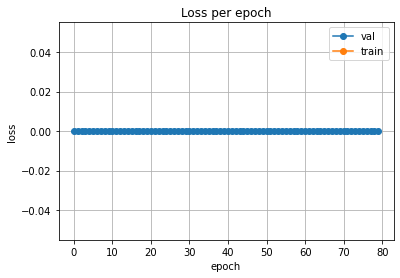

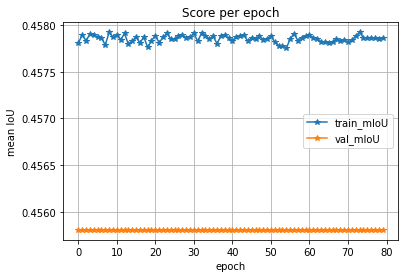

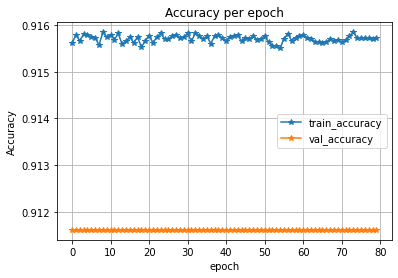

In [39]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## 추론

#### 마스크를 RLE 형태로 변환해주는 함수

In [31]:
def mask_to_rle(mask):
    flatten_mask = mask.flatten()
    if flatten_mask.max() == 0:
        return f'0 {len(flatten_mask)}'
    idx = np.where(flatten_mask!=0)[0]
    steps = idx[1:]-idx[:-1]
    new_coord = []
    step_idx = np.where(np.array(steps)!=1)[0]
    start = np.append(idx[0], idx[step_idx+1])
    end = np.append(idx[step_idx], idx[-1])
    length = end - start + 1
    for i in range(len(start)):
        new_coord.append(start[i])
        new_coord.append(length[i])
    new_coord_str = ' '.join(map(str, new_coord))
    return new_coord_str

#### Test 데이터셋 불러오기

In [32]:
class TestDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        imname = row['img']
        image_path = os.path.join(self.img_dir,imname)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        image = torch.Tensor(image) / 255.0
        
        return image,imname

#### 경로 및 기타 인자 설정

In [33]:
TEST_DIR = os.path.join(DATA_DIR, 'test') # 테스트 데이터가 들어있는 폴더 경로
TEST_IMG_DIR = os.path.join(TEST_DIR, 'images') # 테스트 이미지가 들어있는 폴더 경로
TEST_CSV_FILE = os.path.join(TEST_DIR, 'testdf.csv') # 테스트 이미지 이름이 들어있는 CSV 경로

#### 테스트 Dataset, DataLoader 설정

In [34]:
testdf = pd.read_csv(TEST_CSV_FILE)
test_dataset = TestDataset(testdf, TEST_IMG_DIR)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,shuffle=False)

#### 최고 성능 모델 불러오기

In [35]:
model.load_state_dict(torch.load(os.path.join(RECORDER_DIR, 'best-model.pt')))
# model.load_state_dict(torch.load(os.path.join('', 'best-model.pt'))) # 끊긴 경우

<All keys matched successfully>

#### 추론 진행

In [36]:
file_list = [] # 이미지 이름 저장할 리스트
pred_list = [] # 마스크 저장할 리스트
class_list = [] # 클래스 이름 저장할 리스트 ('building')

model.eval()
with torch.no_grad():
    for batch_index, (image,imname) in tqdm(enumerate(test_loader)):
        image = image.to(device)
        logit_mask = model(image)
        pred_mask = torch.sigmoid(logit_mask) # logit 값을 probability score로 변경
        pred_mask = (pred_mask > 0.5) * 1.0 # 0.5 이상 확률 가진 픽셀값 1로 변환
        pred_rle = mask_to_rle(pred_mask.detach().cpu().squeeze(0)) # 마스크를 RLE 형태로 변경
        pred_list.append(pred_rle)
        file_list.append(imname[0])
        class_list.append("building")
        

1303it [09:30,  2.28it/s]


#### 예측 결과 파일 만들기

In [37]:
# 예측 결과 데이터프레임 만들기
results = pd.DataFrame({'img_id':file_list,'class':class_list,'prediction':pred_list})

# sample_submission.csv와 같은 형태로 변형
sampledf = pd.read_csv(os.path.join(TEST_DIR, 'sample_submission.csv'))
sorter = list(sampledf['img_id'])
results = results.set_index('img_id')
results = results.loc[sorter].reset_index()
                       
# 결과 저장
results.to_csv(os.path.join(RECORDER_DIR, 'prediction.csv'), index=False)

## 참고자료 


- https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch
- https://light-tree.tistory.com/216
-
-

In [37]:
image, mask = test_dataset[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_dataset):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_dataset)

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()